This is a journal used to create the data ingestion and processing pipeline for generating air quality index as part of the NASA Spaceapps challenge 2025. This will involve a number of steps
1. Data ingestion and formatting
2. Exploratory data analysis
3. Data transformation - Structuring data for use with typical geospatial analysis tools
4. Exporting data as geojson file

In [1]:
# Import required libraries for data fusion and geospatial analysis
import pandas as pd
import geopandas as gpd
import pyreadr
import rasterio
import matplotlib.pyplot as plt
import numpy as np      

In [47]:
# Initial testing will use the elemental carbon (EC) data from the 2019 Earth Observatory dataset. This data is formatted as an RDS file, so 
# a bit of work will be needed to convert it to a more useable format. First, we will get it into a dataframe and take a look at the structure.
# ecData = pyreadr.read_r('sourceData/aqdh_pm25component_ec_2019_urban.rds')
# ecDF = ecData[None]  # Extract the dataframe from the dictionary

# While testing, get the dataframe from the trimmed csv file
ecDF = pd.read_csv('processedData/ec_2019_georgia_trimmed.csv')
print(ecDF.describe())

                 lon            lat             ec
count  562944.000000  562944.000000  562944.000000
mean      -82.784444      32.169950       0.454138
std         0.569963       0.481651       0.080599
min       -83.605164      31.393817       0.268689
25%       -83.299735      31.698044       0.395658
50%       -82.837293      32.204107       0.446576
75%       -82.335433      32.561379       0.506633
max       -81.839730      33.000659       0.808653


In [51]:
# Trim the data for our area of interest, using lat/long bounds for the state of Georgia, USA
minLat, maxLat = 32.757851, 33.0
deltaLat = maxLat - minLat
minLonStart = -83.605164
minLon, maxLon = minLonStart, minLonStart + deltaLat * 1.5  # Approximate aspect ratio of Georgia
# minLon, maxLon = -84.797259, -83.560665  # More accurate bounds for Georgia

trimmedEC = ecDF[(ecDF['lat'] >= minLat) & (ecDF['lat'] <= maxLat) & (ecDF['lon'] >= minLon) & (ecDF['lon'] <= maxLon)]

# We'll also rename the third column to something easier to work with and describe the data to get a sense of the distribution of EC values
trimmedEC = trimmedEC.rename(columns={trimmedEC.columns[2]: 'ec'})
print(trimmedEC.head())

# Let's also view the data info to get a sense of the distribution of data types and check for any missing values
print(trimmedEC.info())

# Save this trimmed file for easy testing later
#trimmedEC.to_csv('processedData/ec_2019_georgia_trimmed.csv', index=False)


             lon        lat        ec
25175 -83.501480  32.999957  0.389394
25176 -83.500922  32.999895  0.386008
25177 -83.500364  32.999834  0.385998
25336 -83.505461  32.999943  0.400712
25337 -83.504903  32.999881  0.400643
<class 'pandas.core.frame.DataFrame'>
Index: 42542 entries, 25175 to 92186
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lon     42542 non-null  float64
 1   lat     42542 non-null  float64
 2   ec      42542 non-null  float64
dtypes: float64(3)
memory usage: 1.3 MB
None


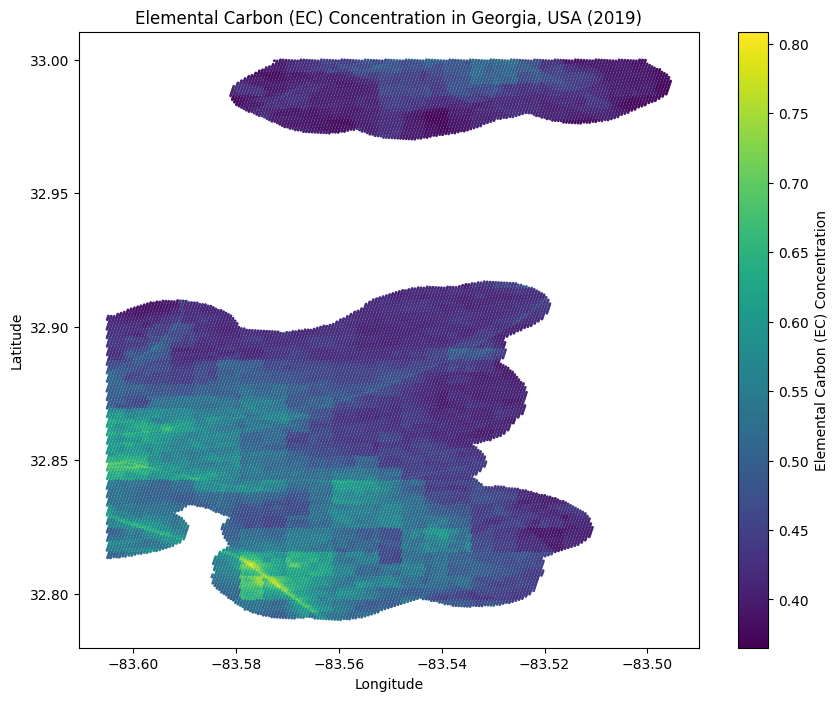

In [52]:
# The description of the data says these are grid cells with a resolution of 50m for urban areas, and 1km for rural area. We can visualize the data to confirm this.
plt.figure(figsize=(10, 8))
plt.scatter(trimmedEC['lon'], trimmedEC['lat'], c=trimmedEC['ec'], cmap='viridis', s=1)
plt.colorbar(label='Elemental Carbon (EC) Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Elemental Carbon (EC) Concentration in Georgia, USA (2019)')
plt.show()  

In [56]:
# The data looks good, and we can see the higher resolution in urban areas. Next steps will be to establish a grid 
# for interpolation and fusion with other datasets.

# We will use geopandas to create a 50m grid cell around it and assign the EC value to that cell. This will help in visualizing and analyzing the data.
geometry = gpd.points_from_xy(trimmedEC['lon'], trimmedEC['lat'])
geoDF = gpd.GeoDataFrame(trimmedEC, geometry=geometry)
geoDF.set_crs(epsg=4326, inplace=True)  # Set coordinate reference system to WGS84

# Create 25m buffer around each point to represent the grid cell
arc = 0.000225  # Approximate degree equivalent for 25m at mid-latitudes
geoDF['geometry'] = geoDF.geometry.buffer(arc)
print(geoDF.head())

C:\Users\danes\AppData\Local\Temp\ipykernel_5036\3754902243.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geoDF['geometry'] = geoDF.geometry.buffer(arc)


             lon        lat        ec  \
25175 -83.501480  32.999957  0.389394   
25176 -83.500922  32.999895  0.386008   
25177 -83.500364  32.999834  0.385998   
25336 -83.505461  32.999943  0.400712   
25337 -83.504903  32.999881  0.400643   

                                                geometry  
25175  POLYGON ((-83.50125 32.99996, -83.50126 32.999...  
25176  POLYGON ((-83.5007 32.9999, -83.5007 32.99987,...  
25177  POLYGON ((-83.50014 32.99983, -83.50014 32.999...  
25336  POLYGON ((-83.50524 32.99994, -83.50524 32.999...  
25337  POLYGON ((-83.50468 32.99988, -83.50468 32.999...  


In [57]:
geoDF.describe()

# Normalize the EC values for better visualization
geoDF['ec_normalized'] = (geoDF['ec'] - geoDF['ec'].min()) / (geoDF['ec'].max() - geoDF['ec'].min())
print(geoDF[['ec', 'ec_normalized']].describe())

                 ec  ec_normalized
count  42542.000000   42542.000000
mean       0.476585       0.251096
std        0.066169       0.149230
min        0.365248       0.000000
25%        0.422098       0.128213
50%        0.458927       0.211272
75%        0.522405       0.354432
max        0.808653       1.000000


In [58]:
# Now we use use geopandas to export this as a geojson file for use in our web application
geoDF.to_file('processedData/ec_2019_georgia.geojson', driver='GeoJSON')